In [1]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.datasets import make_classification
#!{sys.executable} -m pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, load_digits
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve


In [2]:
#imports dataframes train and test
df_train = pd.read_excel("Train.xlsx")
df_test_to_pred = pd.read_excel("Test.xlsx")

# INITIAL EXPLORATION, CLEANING & FEATURE ENGINEERING

In [3]:
#SOME CLEANING

In [4]:
#replaces ? with np.nan
df_train.replace('?', np.nan, inplace=True)
df_test_to_pred.replace('?', np.nan, inplace=True)

In [5]:
#replaces nan with np.nan
df_train.replace('nan', np.nan, inplace=True)
df_test_to_pred.replace('nan', np.nan, inplace=True)

In [6]:
# count of missing values for train #test is similar
#df_train.isna().sum()

In [7]:
#deals with missing values categorical features differently:

#feel comfortable replacing NaNs in 'Emplyment Sector' by mode coz vast majority of entries belong to same class, so this won't have a big impact
modes = df_train['Employment Sector'].mode().loc[0]
df_train['Employment Sector'].fillna(modes, inplace=True)
modes = df_test_to_pred['Employment Sector'].mode().loc[0]
df_test_to_pred['Employment Sector'].fillna(modes, inplace=True)

#since "Role" value_counts are so well distributed, we cannot simply replace missing values with mode; best solution here would be to create new categorical of "Unknown"
df_train['Role'].fillna('Unknown', inplace=True)
df_test_to_pred['Role'].fillna('Unknown', inplace=True)

#Base Are in test with mode as well
modes = df_train['Base Area'].mode().loc[0]
df_train['Base Area'].fillna(modes, inplace=True)
modes = df_test_to_pred['Base Area'].mode().loc[0]
df_test_to_pred['Base Area'].fillna(modes, inplace=True)

#df_test.isna().sum() #checking how many NaNs we still have

In [8]:
#replaces index by ID of citizens; drops previous
df_train = df_train.set_index('CITIZEN_ID', drop=True)
df_test_to_pred = df_test_to_pred.set_index('CITIZEN_ID', drop=True)

In [9]:
#SOME FEATURE ENGINEERING

In [10]:
#splits pronoun of person and it's name,m to be able to infer gender for each person
df_train[['Gender','Name']] = df_train.Name.str.split(" ", n=1, expand=True)
df_test_to_pred[['Gender','Name']] =  df_test_to_pred.Name.str.split(" ", n=1, expand=True)

#df_train['Gender'].unique()

df_train['Gender'].replace(['Miss', 'Mrs.', 'Mr.'], [0,0,1],inplace=True)
df_train = df_train.drop("Name", axis=1)
df_test_to_pred['Gender'].replace(['Miss', 'Mrs.', 'Mr.'], [0,0,1],inplace=True)
df_test_to_pred = df_test_to_pred.drop("Name", axis=1)

In [11]:
#calculates age and drops birthay column
birthday = df_train["Birthday"].str.split(",", n=1, expand=True).rename(columns={0:"Day and month", 1:"Year"})
df_train = df_train.assign(Birthday=birthday['Year'])
df_train["Birthday"] = df_train["Birthday"].astype(int)
df_train["Birthday"] = 2048 - df_train["Birthday"]
df_train.rename(columns={'Birthday':'Age'}, inplace=True)

birthday = df_test_to_pred["Birthday"].str.split(",", n=1, expand=True).rename(columns={0:"Day and month", 1:"Year"})
df_test_to_pred = df_test_to_pred.assign(Birthday=birthday['Year'])
df_test_to_pred["Birthday"] = df_test_to_pred["Birthday"].astype(int)
df_test_to_pred["Birthday"] = 2048 - df_test_to_pred["Birthday"]
df_test_to_pred.rename(columns={'Birthday':'Age'}, inplace=True)

In [12]:
#SOME DATA EXPLORATION

In [13]:
metric_features = ['Age', 'Years of Education', 'Working Hours per week', 'Money Received', 'Ticket Price']
non_metric_features = ['Native Continent', 'Marital Status', 'Lives with', 'Base Area', 'Education Level', 'Employment Sector', 'Role']

In [14]:
#Pairwise Relationship of Numerical Variables
#sns.set()

# Setting pairplot
#sns.pairplot(df_train[metric_features], diag_kind="hist")

# Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

#plt.show()

#There doesn't seem to exist much obvious relationships between numerical variables; values are distributed throughout distribution plot

In [15]:
#def cor_heatmap(cor):
    #plt.figure(figsize=(12,10))
    #sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    #plt.show()
    
#cor_pearson = df_train[metric_features].corr(method = 'spearman')
#cor_heatmap(cor_pearson)'''

In [16]:
#Proportion Plots

In [17]:
#def bar_charts_categorical(df, feature, target):
    #cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    #categories = cont_tab.index[:-1]
        
    #fig = plt.figure(figsize=(15, 5))
    
    #plt.subplot(121)
    #p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    #p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="skyblue")
    #plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    #plt.xticks(rotation='vertical')
    #plt.title("Frequency bar chart")
    #plt.xlabel(feature)
    #plt.ylabel("$Frequency$")

    # auxiliary data for 122
    #obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        #np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    #plt.subplot(122)
    #p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    #p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="skyblue")
    #plt.xticks(rotation='vertical')
    #plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    #plt.title("Proportion bar chart")
    #plt.xlabel(feature)
    #plt.ylabel("$p$")

    #plt.show()

In [18]:
#Based on an initial observation of these proportions plots, the variables "Native Continent" and "Base Area" concentrate the vast majority of all instances in teh same values; thus, these will be variables that will only biase the model and won't be bringing any discriminative power to it; for these reasons, we will be dropping them here.

In [19]:
df_train.drop('Base Area', axis = 1, inplace=True)
df_test_to_pred.drop('Base Area', axis = 1, inplace=True)

df_train.drop('Native Continent', axis = 1, inplace=True)
df_test_to_pred.drop('Native Continent', axis = 1, inplace=True)

In [20]:
#FURHER FEATURE ENGINEERING

In [21]:
#ONE-HOT ENCODING TO ENCODE CATEGORICAL VARIABLES

In [22]:
df_ohc_train = df_train.copy()
df_ohc_test = df_test_to_pred.copy()

In [23]:
non_metric_features = ['Employment Sector', 'Marital Status', 'Lives with', 'Education Level', 'Role']

In [24]:
ohc = OneHotEncoder(sparse=False, drop='first')
ohc_feat_train = ohc.fit_transform(df_ohc_train[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_train = pd.DataFrame(ohc_feat_train, index=df_ohc_train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?

ohc = OneHotEncoder(sparse=False, drop='first')
ohc_feat_test = ohc.fit_transform(df_ohc_test[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_test = pd.DataFrame(ohc_feat_test, index=df_ohc_test.index, columns=ohc_feat_names)

In [25]:
df_ohc_train = pd.concat([df_ohc_train.drop(columns=non_metric_features), ohc_df_train], axis=1)
df_ohc_test = pd.concat([df_ohc_test.drop(columns=non_metric_features), ohc_df_test], axis=1)

In [26]:
#CHECKING FOR OUTLIERS

In [27]:
df_outlier_train = df_ohc_train.copy()
df_outlier_test = df_ohc_test.copy()

In [28]:
#applies log(x+1) in ticket price and money recieved columns
df_outlier_train[['Ticket Price', 'Money Received']] = df_outlier_train[['Ticket Price', 'Money Received']].apply(lambda x: np.log1p(x))
df_outlier_test[['Ticket Price', 'Money Received']] = df_outlier_test[['Ticket Price', 'Money Received']].apply(lambda x: np.log1p(x))


In [29]:
# Prepare figure. Create individual axes where each box plot will be placed
#fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(18, 8))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
#for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    #sns.boxplot(x=df_outlier_train[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
#title = "Numeric Variables' Box Plots"

#plt.suptitle(title)

#plt.show()


In [30]:
#from numpy import percentile
#from scipy import stats

#for feature in metric_features:
    # calculate interquartile range
    #q25, q75 = percentile(df_outlier_train[feature], 25), percentile(df_outlier_train[feature], 75)
    #iqr = q75 - q25
    # calculate the outlier cutoff
    #cut_off = iqr * 1.5
    #lower, upper = q25 - cut_off, q75 + cut_off

    #df_outlier_train[feature] = df_outlier_train[feature][((df_outlier_train[feature] < upper) & (df_outlier_train[feature] > lower))]
    
#from scipy import stats
#df_outlier_train=df_outlier_train[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

Upon investigation of the distribution of our numerical variables, we concluded that none of the datapoints that appear outside of the whiskers of the boxplots (see above) seem to be measurement errors, data entry errors or not part of the population in study (as they all make sense in the numerical range of the corresponding variable), i.e. they seem to be natural variations of the data distributions. While these are oddballs, they accurately reflect the potential surprises and uncertainty inherent in ages, years of education or working hours per week. For the particular case of the variables Money Received and Ticket Price, a similar logical can be followed, as extreme values of "Money Received" can be consider extremely important/necessary/influencial persons being recruited to the mission, and neither the values of this variable or the variable Ticket Price are unreasonable. However, we do acknoweledge that having such a wide range or extreme values in this two particular variables can be detrimental to the performance of our model, so we applied a log transformation to them, as an attempt to reduce the variance between these datapoints (although we didn't find evidence for differnet performance in our final model, with or without log application!). Even if our final model performs better after removing these datapoints (which we don't think it is the case since our final model is based in decision trees, which are known to be very robust to outliers (REFS)), the model would make make the process appear more predictable than it actually is. Even though these unusual observations can influence the model performance, we made the decision of keeping them, as it is bad practice to remove data points just for the sake of simply producing a better fitting model or statistically significant results.

In [31]:
#All Numeric Variables' Histograms in one figure
#sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
#fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(18, 8))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
#for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    #ax.hist(df_outlier_train[feat])
    #ax.set_title(feat)
    #ax.set_xlim(min(df_outlier_train[feat]), max(df_outlier_train[feat]))
    
# Layout
# Add a centered title to the figure:
#title = "Numeric Variables' Histograms"

#plt.suptitle(title)

#plt.show()

In [32]:
#NORMALIZING DATA

In [33]:
df_normalization_train = df_outlier_train.copy()
df_normalization_test = df_outlier_test.copy()

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
#scaler = RobustScaler()
#try MinMax with feature_range=(-1,1) as well
df_normalization_train_metric = pd.DataFrame(scaler.fit_transform(df_normalization_train[metric_features]), index=df_normalization_train.index, columns=metric_features)
df_normalization_test_metric = pd.DataFrame(scaler.fit_transform(df_normalization_test[metric_features]), index=df_normalization_test.index, columns=metric_features)

In [35]:
df_normalization_train = pd.concat([df_normalization_train.drop(columns=metric_features), df_normalization_train_metric], axis=1)
df_normalization_test = pd.concat([df_normalization_test.drop(columns=metric_features), df_normalization_test_metric], axis=1)

# INITIAL FEATURE SELECTION

In [36]:
df_fselection_train = df_normalization_train.copy()
df_fselection_test = df_normalization_test.copy()

In [37]:
#defines numerical and categorical variables
numerical_variables = ['Age', 'Years of Education', 'Working Hours per week', 'Ticket Price', "Money Received"]
categorical_variables = [variable for variable in df_fselection_train.columns if variable not in numerical_variables]
categorical_variables.remove('Income') #lets drop the dependent variable

1. Correlation numerical variables

<AxesSubplot:>

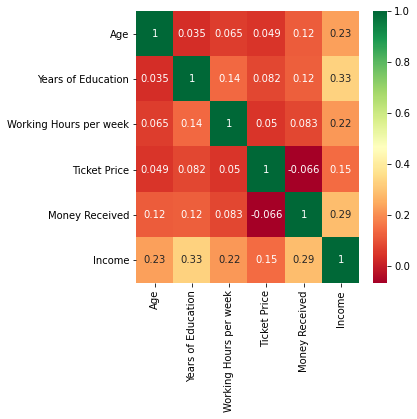

In [38]:
#Correlation Matrix with Heatmap
plt.figure(figsize=(5,5))
#plot heat map
df=pd.concat([df_fselection_train[numerical_variables], df_fselection_train['Income']], axis=1)
sns.heatmap(df.corr(method='pearson'), annot=True, cmap="RdYlGn")

Since none of the numerical features are highly (un)correlated between themselves, we're gonna keep them all!

ATENTION: We'll be applying Chi2 and MIC for feature selection of categoricals, coz that's what the scheme from classes says it's good! Apply then some other for the continuous!

In [39]:
X = df_fselection_train.drop("Income", axis=1)[categorical_variables]
y = df_fselection_train["Income"]

1. Chi2 for Categorical Variables

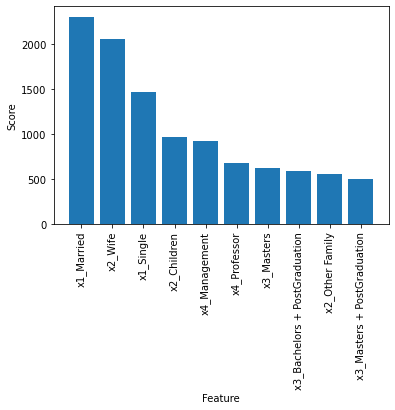

In [40]:
threshold = 10
high_score_features_chi2 = []
scores = []
names_Chi2 = []

feature_scores = SelectKBest(chi2, k=threshold).fit(X,y).scores_

high_score_features = []
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        high_score_features_chi2.append(f_name)
        scores.append(score)
        names_Chi2.append(f_name)
 
plt.bar(names_Chi2, scores)
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.xlabel('Feature')
plt.show()

2. MIC for Categorical Variables

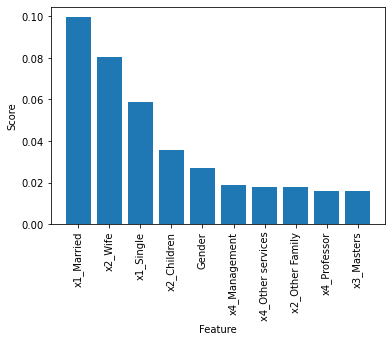

In [41]:
#Feature selection applying MIC for categorical variables- saw that, from the scheme of the theoretical class, 
#that this is the best method for categorical variables and categorical output
threshold = 10 #selects number of most relevant features
high_score_features_MIC = []
scores = []
names_MIC = []
feature_scores = mutual_info_classif(X, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        high_score_features_MIC.append(f_name)
        scores.append(score)
        names_MIC.append(f_name)
plt.bar(names_MIC, scores)
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.xlabel('Feature')
plt.show()

In [42]:
###We're gonna use the intersection of the features chosen by both this models!

common_categorical_features = list(set(names_Chi2).intersection(list(names_MIC)))

features_selected = common_categorical_features + numerical_variables

In [43]:
features_selected

['x2_Wife',
 'x1_Married',
 'x2_Other Family',
 'x4_Professor',
 'x3_Masters',
 'x1_Single',
 'x2_Children',
 'x4_Management',
 'Age',
 'Years of Education',
 'Working Hours per week',
 'Ticket Price',
 'Money Received']

# MODEL TESTING & SELECTION

We will divide the training/validation set in a test set as well, to actually make predictions and further check how the model is behaving. We can afford to do this as we have quite a big of a dataset.

In [44]:
df_train_validation_test = df_fselection_train.copy().drop('Income', axis = 1)[features_selected]
df_test = df_fselection_test.copy()[features_selected]

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df_train_validation_test,
                                                  df_fselection_train["Income"],
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=df_fselection_train["Income"])

In [46]:
#run desired model
def run_model(model_name, X, y):
    
    ###STANDALONE MODELS
    if model_name == 'KNN':
        #Manhattan distance, which should work better for high dimensional datasets
        #weights to attribute higher weight to closer neighbors; seems to improve score highly
        model = KNeighborsClassifier(n_neighbors=10, p = 1, weights='distance').fit(X, y) #
    if model_name == 'LR':
        model = LogisticRegression().fit(X, y) #
    if model_name == 'NB': 
        model = GaussianNB().fit(X, y)
    if model_name == 'BNB': #
        model = BernoulliNB().fit(X, y)
    if model_name == 'MNB': #
        model = MultinomialNB().fit(X, y)
    if model_name == 'NN': #
        model = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000).fit(X, y)
    if model_name == 'DT':
        model = DecisionTreeClassifier(criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y) #max_features=6,
    if model_name == 'SVM': #
        model = svm.SVC(C=0.05, degree=2, gamma='scale', kernel='rbf').fit(X, y)
    
    ###ENSEMBLES
    if model_name == 'RF':
        model = RandomForestClassifier(max_depth = 11, random_state = 5, n_estimators=500, min_samples_leaf = 3).fit(X, y) #max_features=6, #max_depth é super imp para reduzir overfitting! #min_samples_lead highly reduces overfitting!
    if model_name == 'Bagg_NN':
        model = BaggingClassifier(base_estimator = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000), n_estimators = 5, random_state = 5).fit(X, y)
    if model_name == 'AdaBoost':
        model = AdaBoostClassifier(n_estimators = 95, learning_rate = 0.8, random_state = 5).fit(X, y) #importante que GSearchCV em DT maximizado!
    if model_name == 'GBoost':
        model = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15).fit(X, y)
    
    return model


In [47]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'GBoost':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [48]:
###STANDALONE MODELS:

#runs each Repeated (10) 10-fold Cross-Validation in all tested models by calling function avg_score and prints resutls with multiple metrics for each

method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_KNN = avg_score(method_cv, X_train_val, y_train_val, 'KNN')
results_LR = avg_score(method_cv, X_train_val, y_train_val, 'LR')
results_NB = avg_score(method_cv, X_train_val, y_train_val, 'NB')
results_BNB = avg_score(method_cv, X_train_val, y_train_val, 'BNB')
results_MNB = avg_score(method_cv, X_train_val, y_train_val, 'MNB')
results_NN = avg_score(method_cv, X_train_val, y_train_val, 'NN')
results_DT = avg_score(method_cv, X_train_val, y_train_val, 'DT')
resultsSVM = avg_score(method_cv, X_train_val, y_train_val, 'SVM')


In [49]:
results_models = [results_KNN, results_LR, results_NB, results_BNB, results_MNB, results_NN, results_DT, resultsSVM]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM'])

df

,KNN,LR,NB,BNB,MNB,NN,DT,SVM
Train Accuracy (F1 Score micro),0.944+/-0.001,0.836+/-0.001,0.758+/-0.003,0.721+/-0.001,0.821+/-0.001,0.848+/-0.005,0.868+/-0.002,0.825+/-0.001
Validation Accuracy (F1 Score micro),0.828+/-0.0,0.836+/-0.0,0.757+/-0.0,0.721+/-0.0,0.821+/-0.0,0.845+/-0.0,0.851+/-0.0,0.825+/-0.0
Test Accuracy (F1 Score micro),0.835,0.842,0.771,0.728,0.829,0.855,0.861,0.829
Precision Train,0.953+/-0.004,0.703+/-0.002,0.494+/-0.003,0.451+/-0.001,0.651+/-0.003,0.73+/-0.031,0.809+/-0.016,0.665+/-0.003
Precision Validation,0.666+/-0.024,0.702+/-0.025,0.493+/-0.012,0.451+/-0.01,0.651+/-0.025,0.725+/-0.04,0.759+/-0.032,0.664+/-0.024
Precision Test,0.681,0.72,0.51,0.458,0.673,0.749,0.78,0.677
Recall Train,0.802+/-0.004,0.535+/-0.003,0.842+/-0.003,0.808+/-0.002,0.528+/-0.002,0.573+/-0.045,0.584+/-0.021,0.527+/-0.002
Recall Validation,0.55+/-0.023,0.534+/-0.022,0.841+/-0.015,0.808+/-0.017,0.528+/-0.019,0.569+/-0.051,0.547+/-0.025,0.527+/-0.02
Recall Test,0.574,0.543,0.858,0.815,0.54,0.583,0.576,0.536
Time,0.237+/-0.02,0.037+/-0.004,0.005+/-0.001,0.005+/-0.001,0.003+/-0.0,1.425+/-0.52,0.022+/-0.001,3.193+/-0.048


In [50]:
models = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM']
'''
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test):
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (10, 5))

    #sets style of the plot to increase readibility
    sns.set_style(style="whitegrid")

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6

    #makes the plot
    plt.bar(pos_train, f1micro_train, color='dodgerblue', width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color='steelblue', width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color='skyblue', width=barwidth, edgecolor='white', label='Validation')

    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')

    #personalizes yticks to inrease readibility of data in the plot
    ax.set_yticks(np.arange(0, 1, 0.1))

    #ads title to the plot
    plt.title('10-fold Repeated Cross-Validation Results', fontsize = 14)

    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)

    #shows plot
    plt.show()
    
plt_bar(models, f1micro_train, f1micro_val, f1micro_test)'''

'\ndef plt_bar(models, f1micro_train, f1micro_val, f1micro_test):\n    \n    #Creates a figure and a set of subplots\n    fig, ax = plt.subplots(figsize = (10, 5))\n\n    #sets style of the plot to increase readibility\n    sns.set_style(style="whitegrid")\n\n    #set width of bar\n    barwidth = 0.3\n\n    #set position of bar on X axis\n    pos_train = np.arange(len(f1micro_test))\n    pos_val = np.arange(len(f1micro_test))+0.3\n    pos_test = np.arange(len(f1micro_test))+0.6\n\n    #makes the plot\n    plt.bar(pos_train, f1micro_train, color=\'dodgerblue\', width=barwidth, edgecolor=\'white\', label=\'Train\')\n    plt.bar(pos_val, f1micro_val, color=\'steelblue\', width=barwidth, edgecolor=\'white\', label=\'Validation\')\n    plt.bar(pos_test, f1micro_test, color=\'skyblue\', width=barwidth, edgecolor=\'white\', label=\'Validation\')\n\n    #sets x, y labels\n    ax.set(xlabel = \'Model\', ylabel = \'Accuracy\')\n\n    #sets x ticks locations and designation\n    ax.set_xticks((po

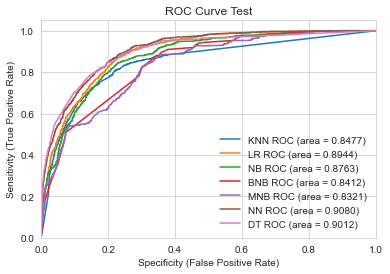

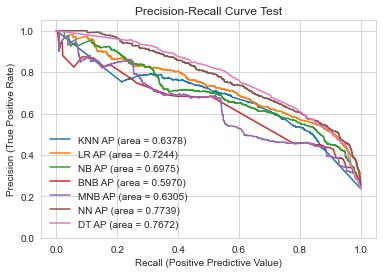

In [51]:
plt.figure()

# Add models to list of models to incorporte in ROC curve
models = [{'label': 'KNN', 'model': run_model('KNN', X_train_val, y_train_val),},
          {'label': 'LR', 'model': run_model('LR', X_train_val, y_train_val),},
          {'label': 'NB','model': run_model('NB', X_train_val, y_train_val),},
          {'label': 'BNB', 'model': run_model('BNB', X_train_val, y_train_val),},
          {'label': 'MNB', 'model': run_model('MNB', X_train_val, y_train_val),},
          {'label': 'NN', 'model': run_model('NN', X_train_val, y_train_val),},
          {'label': 'DT', 'model': run_model('DT', X_train_val, y_train_val),},] 
            #SVM not included coz there's no probs!

    
def plot_roc_pr(models, X, y):  
    sns.set_style(style="whitegrid")
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC Curve Test')
    plt.legend(loc="lower right", frameon=False)
    plt.show()

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)')
    plt.ylabel('Precision (True Positive Rate)')
    plt.title('Precision-Recall Curve Test')
    plt.legend(loc="lower left", frameon=False)
    plt.show()

plot_roc_pr(models, X_test, y_test)

Given the fact that Decision Trees were a standalone model that yielded the best results (along with Neural Networks and Logistic Regression), we decided to try out a few ensemble methods that have Decision Trees as base learners:

In [52]:
method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_Bagg_NN = avg_score(method_cv, X_train_val, y_train_val, 'Bagg_NN')
results_RF = avg_score(method_cv, X_train_val, y_train_val, 'RF')
results_AdaBoost = avg_score(method_cv, X_train_val, y_train_val, 'AdaBoost')
results_GBoost = avg_score(method_cv, X_train_val, y_train_val, 'GBoost')


In [53]:
results_models = [results_Bagg_NN, results_RF, results_AdaBoost, results_GBoost]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['Bagg_NN', 'RF', 'AdaBoost', 'GBoost'])

print('Averaged Confusion Matrix for GBoost:\n', results_models[3][10])

df 

Averaged Confusion Matrix for GBoost:
 [[1294.94   72.16]
 [ 172.98  251.92]]


,Bagg_NN,RF,AdaBoost,GBoost
Train Accuracy (F1 Score micro),0.852+/-0.002,0.87+/-0.001,0.858+/-0.001,0.869+/-0.001
Validation Accuracy (F1 Score micro),0.85+/-0.0,0.859+/-0.0,0.856+/-0.0,0.863+/-0.0
Test Accuracy (F1 Score micro),0.854,0.861,0.862,0.869
Precision Train,0.739+/-0.015,0.819+/-0.004,0.767+/-0.004,0.794+/-0.003
Precision Validation,0.733+/-0.028,0.788+/-0.025,0.764+/-0.022,0.778+/-0.024
Precision Test,0.761,0.803,0.786,0.801
Recall Train,0.582+/-0.019,0.579+/-0.005,0.574+/-0.005,0.603+/-0.004
Recall Validation,0.579+/-0.031,0.554+/-0.024,0.572+/-0.024,0.593+/-0.025
Recall Test,0.562,0.549,0.577,0.598
Time,6.984+/-0.917,2.415+/-0.017,0.535+/-0.006,1.393+/-0.06


In [54]:
models = ['Bagg NN', 'RF', 'AdaBoost', 'GBoost']

#plt_bar(models, f1micro_train, f1micro_val, f1micro_test)

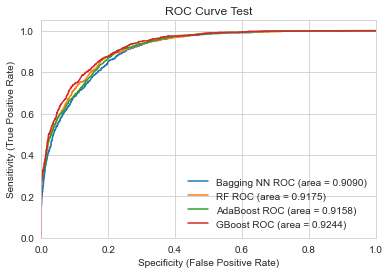

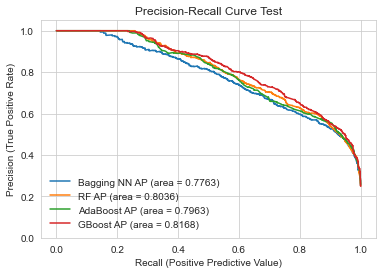

In [55]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'Bagging NN', 'model': run_model('Bagg_NN', X_train_val, y_train_val),},
          {'label': 'RF', 'model': run_model('RF', X_train_val, y_train_val),},
          {'label': 'AdaBoost','model': run_model('AdaBoost', X_train_val, y_train_val),},
          {'label': 'GBoost', 'model': run_model('GBoost', X_train_val, y_train_val),}]


plot_roc_pr(models, X_test, y_test)

In an attempt to try to get a better performing model, we next tried a particular class of ensemble methods: stacking methods. Here, we tried a few combination of algorithms, with different combinations of strong and weak learners:

In [56]:
# get a stacking ensemble of models
def get_stacking(model_name, X, y):

    level0 = list()
    
    if 'LR' in model_name:
        base_learner = LogisticRegression()
        level0.append(('LR', base_learner))
    if 'NB' in model_name:
        base_learner = GaussianNB()
        level0.append(('NB', base_learner))
    if 'BNB' in model_name:
        base_learner = BernoulliNB()
        level0.append(('BNB', base_learner))
    if 'MNB' in model_name:
        base_learner = MultinomialNB()
        level0.append(('MNB', base_learner))
    if 'NN' in model_name:
        base_learner = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000)
        level0.append(('NN', base_learner))
    if 'DT' in model_name:
        base_learner = DecisionTreeClassifier(criterion='entropy', max_depth = 14, min_samples_split= 50)
        level0.append(('DT', base_learner))
    if 'SVM' in model_name:
        base_learner = svm.SVC(C=0.05, degree=2, gamma='scale', kernel='rbf')
        level0.append(('SVM', base_learner))
    if 'RF' in model_name:
        base_learner = RandomForestClassifier(max_depth = 11, random_state = 5, n_estimators=500, min_samples_leaf = 3) #max_features=6, #max_depth é super imp para reduzir overfitting! #min_samples_lead highly reduces overfitting!
        level0.append(('RF', base_learner))
    if 'AdaBoost' in model_name:
        base_learner = AdaBoostClassifier(n_estimators = 95, learning_rate = 0.8, random_state = 5)
        level0.append(('AdaBoost', base_learner))
    if 'GBoost' in model_name:
        base_learner = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15)
        level0.append(('GBoost', base_learner))
    
    
    #defines meta learner model
    level1 = LogisticRegression()
    
    #stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    model = model.fit(X, y)
    
    return model

In [57]:
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    
    precision_train = []
    precision_val = []
    
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = get_stacking(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == ('GBoost', 'NB'):
            cm_holder.append(confusion_matrix(y_val, labels_val)) #gets averaged confusion matrix for this algorithm, for comparison w/ GBoost alone
        
    model = get_stacking(model_name, X, y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [58]:
method_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state = 15)

print('model1')
model1 = avg_score(method_cv, X_train_val, y_train_val, ('RF', 'NN')) ###
#print('model2')
#model2 = avg_score(method_cv, X_train_val, y_train_val, ('RF', 'NB'))
#print('model3')
#model3 = avg_score(method_cv, X_train_val, y_train_val, ('NN', 'NB'))
#print('model4')
#model4 = avg_score(method_cv, X_train_val, y_train_val, ('RF', 'SVM'))
#print('model5')
#model5 = avg_score(method_cv, X_train_val, y_train_val, ('NB', 'SVM'))
print('model6')
model6 = avg_score(method_cv, X_train_val, y_train_val,('GBoost', 'NB')) ###
print('model7')
model7 = avg_score(method_cv, X_train_val, y_train_val, ('GBoost', 'SVM')) ###
print('model8')
model8 = avg_score(method_cv, X_train_val, y_train_val, ('Gboost', 'NN')) ###
#print('model9')
#model9 = avg_score(method_cv, X_train_val, y_train_val, ('MNB', 'NB', 'DT'))
#print('model10')
#model10 = avg_score(method_cv, X_train_val, y_train_val, ('GBoost', 'LR'))
#print('model11')
#model11 = avg_score(method_cv, X_train_val, y_train_val, ('GBoost', 'AdaBoost'))
#print('model12')
#model12 = avg_score(method_cv, X_train_val, y_train_val, ('GBoost', 'AdaBoost', 'NB'))
#print('model13')
#model13 = avg_score(method_cv, X_train_val, y_train_val, ('RF', 'NB', 'SVM'))
##print('model14')
##model14 = avg_score(method_cv, X_train_val, y_train_val, ('DT', 'NB', 'SVM'))
#print('model15')
#model15 = avg_score(method_cv, X_train_val, y_train_val, ('LR', 'SVM')) #MT BAIXO
#print('model16')
#model16 = avg_score(method_cv, X_train_val, y_train_val, ('LR', 'NB')) #MT BAIXO
#print('model17')
#model17 = avg_score(method_cv, X_train_val, y_train_val, ('NB', 'LR', 'SVM')) #

model1
model6
model7
model8


In [59]:
results_models = [model1, model7, model8, model6]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['Stack_RF+NN', 'Stack_GBoost+NB', 'Stack_GBoost+SVM', 'Stack_GBoost+NN'])

print('Averaged Confusion Matrix for Stack GBoost+NB:\n', results_models[3][10])

df


Averaged Confusion Matrix for Stack GBoost+NB:
 [[2581.08  153.12]
 [ 342.4   507.4 ]]


,Stack_RF+NN,Stack_GBoost+NB,Stack_GBoost+SVM,Stack_GBoost+NN
Train Accuracy (F1 Score micro),0.87+/-0.001,0.869+/-0.002,0.849+/-0.003,0.869+/-0.002
Validation Accuracy (F1 Score micro),0.858+/-0.0,0.862+/-0.0,0.847+/-0.0,0.862+/-0.0
Test Accuracy (F1 Score micro),0.862,0.869,0.84,0.869
Precision Train,0.797+/-0.005,0.792+/-0.005,0.744+/-0.031,0.788+/-0.004
Precision Validation,0.763+/-0.017,0.771+/-0.017,0.738+/-0.035,0.768+/-0.016
Precision Test,0.78,0.789,0.683,0.793
Recall Train,0.605+/-0.007,0.61+/-0.005,0.561+/-0.042,0.61+/-0.005
Recall Validation,0.58+/-0.017,0.596+/-0.019,0.557+/-0.048,0.597+/-0.018
Recall Test,0.584,0.608,0.604,0.608
Time,19.072+/-0.631,18.37+/-0.388,6.969+/-0.892,6.088+/-0.025


In [60]:
models = ['RF+NN','Gboost+NB','GBoost+SVM','GBoost+NN']

#plt_bar(models, f1micro_train, f1micro_val, f1micro_test)

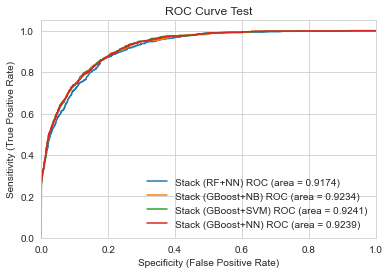

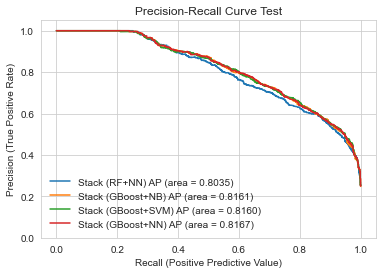

In [61]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'Stack (RF+NN)','model': get_stacking(('RF', 'NN'), X_train_val, y_train_val),},
          {'label': 'Stack (GBoost+NB)','model': get_stacking(('GBoost', 'NB'), X_train_val, y_train_val)},
          {'label': 'Stack (GBoost+SVM)','model': get_stacking(('GBoost', 'SVM'), X_train_val, y_train_val)},
          {'label': 'Stack (GBoost+NN)','model': get_stacking(('GBoost', 'NN'), X_train_val, y_train_val)},]
    
plot_roc_pr(models, X_test, y_test)

# MODEL OPTIMIZATION

In [62]:
#FURTHER FEATURE ENGINEERING:

In [63]:
#it's irrelevant to know if spouse is missing or in the army; even if it's relevant, this is such a small subset (284 and 14, respectively) that this has no power; thus, these values will be considered as just Married, and will thus be changed next:
df_train.loc[df_train["Marital Status"] == 'Married - Spouse in the Army', "Marital Status"] = 'Married'
df_test_to_pred.loc[df_test_to_pred["Marital Status"] == 'Married - Spouse in the Army', "Marital Status"] = 'Married'

#we will also group people who do not have a spouse atm, ie., divorced, separated, single and widow will be aggregated in single; furthermore, all these variables have identical proportions of 1
df_train.loc[df_train["Marital Status"] == 'Married - Spouse Missing', "Marital Status"] = 'Single'
df_test_to_pred.loc[df_test_to_pred["Marital Status"] == 'Married - Spouse Missing', "Marital Status"] = 'Single'
df_train.loc[df_train["Marital Status"] == 'Divorced', "Marital Status"] = 'Single'
df_test_to_pred.loc[df_test_to_pred["Marital Status"] == 'Divorced', "Marital Status"] = 'Single'
df_train.loc[df_train["Marital Status"] == 'Separated', "Marital Status"] = 'Single'
df_test_to_pred.loc[df_test_to_pred["Marital Status"] == 'Separated', "Marital Status"] = 'Single'
df_train.loc[df_train["Marital Status"] == 'Widow', "Marital Status"] = 'Single'
df_test_to_pred.loc[df_test_to_pred["Marital Status"] == 'Widow', "Marital Status"] = 'Single'

In [64]:
#it's irrelevant to know if it's "Wife" or "Husband", they're both "spouse", which will yield more statistical power to the feature, if relevant, and it's one less instance for One hot enconding, wich is good
df_train.loc[df_train["Lives with"] == 'Wife', "Lives with"] = 'Spouse'
df_train.loc[df_train["Lives with"] == 'Husband', "Lives with"] = 'Spouse'
df_test_to_pred.loc[df_test_to_pred["Lives with"] == 'Wife', "Lives with"] = 'Spouse'
df_test_to_pred.loc[df_test_to_pred["Lives with"] == 'Husband', "Lives with"] = 'Spouse'

#all family are aggregated; this increases proportions relative to "Spouse" and proportions of 1's in all are close
df_train.loc[df_train["Lives with"] == 'Other Family', "Lives with"] = 'Family'
df_train.loc[df_train["Lives with"] == 'Other relatives', "Lives with"] = 'Family'
df_train.loc[df_train["Lives with"] == 'Children', "Lives with"] = 'Family'
#df_train.loc[df_train["Lives with"] == 'Alone', "Lives with"] = 'Family'
df_test_to_pred.loc[df_test_to_pred["Lives with"] == 'Other Family', "Lives with"] = 'Family'
df_test_to_pred.loc[df_test_to_pred["Lives with"] == 'Other relatives', "Lives with"] = 'Family'
df_test_to_pred.loc[df_test_to_pred["Lives with"] == 'Children', "Lives with"] = 'Family'
#df_test.loc[df_test["Lives with"] == 'Alone', "Lives with"] = 'Family'

#3 Categories: Spouse, Family and Alone

In [65]:
#we will be aggregating according to lever of education, from <= high school - Professional School - bachelors/postgraduation - masters and PhD; this seems like a logic division, not only given the logic binning regarding academic degrees, but also based on the similar proportions of 1's within each of these groups; this way we also solve the problem of misrepresented groups that exist here
#since we have huge proportions of a particular base area, and very small proportions of all others, this feature will be converted in 0 (if not from most common base area) or 1 (if from most common base area)
df_train.replace(['High School - 2nd Cycle', 'High School - 1st Cycle', 'High School Complete', 'Middle School - 2nd Cycle', 'Middle School Complete', 'Middle School - 1st Cycle', 'Primary School', 'Preschool', 'Professional School'], ['Basic Education']*9, inplace = True)
df_test_to_pred.replace(['High School - 2nd Cycle', 'High School - 1st Cycle', 'High School Complete', 'Middle School - 2nd Cycle', 'Middle School Complete', 'Middle School - 1st Cycle', 'Primary School', 'Preschool', 'Professional School'], ['Basic Education']*9, inplace = True)

df_train.replace(['Bachelors', 'High School + PostGraduation', 'Bachelors + PostGraduation', 'Professional School + PostGraduation'], ['PostGraduation']*4, inplace = True)
df_test_to_pred.replace(['Bachelors', 'High School + PostGraduation', 'Bachelors + PostGraduation', 'Professional School + PostGraduation'], ['PostGraduation']*4, inplace = True)

df_train.replace(['Masters', 'Masters + PostGraduation', 'PhD'], ['Masters/PhD']*3, inplace = True)
df_test_to_pred.replace(['Masters', 'Masters + PostGraduation', 'PhD'], ['Masters/PhD']*3, inplace = True)

In [66]:
#bins all private sector types to "Private Sector";
df_train.replace(['Private Sector - Services ', 'Private Sector - Others'], ['Private Sector','Private Sector'], inplace = True)
df_test_to_pred.replace(['Private Sector - Services ', 'Private Sector - Others'], ['Private Sector','Private Sector'], inplace = True)

#all Public Sector types to "Public Sector";
df_train.replace(['Public Sector - Others', 'Public Sector - Government'], ['Public Sector','Public Sector'], inplace = True)
df_test_to_pred.replace(['Public Sector - Others', 'Public Sector - Government'], ['Public Sector','Public Sector'], inplace = True)

#all Self-Employed types in Self-Employed;
df_train.replace(['Self-Employed (Individual)', 'Self-Employed (Company)'], ['Self-Employed','Self-Employed'], inplace = True)
df_test_to_pred.replace(['Self-Employed (Individual)', 'Self-Employed (Company)'], ['Self-Employed','Self-Employed'], inplace = True)

#and Unemployed and Never worked in "Unemployed"
df_train.replace(['Unemployed', 'Never Worked'], ['Unemployed','Unemployed'], inplace = True)
df_test_to_pred.replace(['Unemployed', 'Never Worked'], ['Unemployed','Unemployed'], inplace = True)

In [67]:
df_train.loc[df_train['Role'] == 'Professor', 'Role'] = 'high'
df_train.loc[df_train['Role'] == 'Management', 'Role'] = 'high'

df_train.loc[df_train['Role'] == 'IT', 'Role'] = 'medium'
df_train.loc[df_train['Role'] == 'Security', 'Role'] = 'medium'
df_train.loc[df_train['Role'] == 'Sales', 'Role'] = 'medium'
df_train.loc[df_train['Role'] == 'Repair & constructions', 'Role'] = 'medium'
df_train.loc[df_train['Role'] == 'Army', 'Role'] = 'medium'

df_train.loc[df_train['Role'] == 'Administratives', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Agriculture and Fishing', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Cleaners & Handlers', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Household Services', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Machine Operators & Inspectors', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Other services', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Transports', 'Role'] = 'low'
df_train.loc[df_train['Role'] == 'Unknown', 'Role'] = 'low'

###

df_test_to_pred.loc[df_test_to_pred['Role'] == 'Professor', 'Role'] = 'high'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Management', 'Role'] = 'high'

df_test_to_pred.loc[df_test_to_pred['Role'] == 'IT', 'Role'] = 'medium'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Security', 'Role'] = 'medium'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Sales', 'Role'] = 'medium'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Repair & constructions', 'Role'] = 'medium'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Army', 'Role'] = 'medium'

df_test_to_pred.loc[df_test_to_pred['Role'] == 'Administratives', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Agriculture and Fishing', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Cleaners & Handlers', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Household Services', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Machine Operators & Inspectors', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Other services', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Transports', 'Role'] = 'low'
df_test_to_pred.loc[df_test_to_pred['Role'] == 'Unknown', 'Role'] = 'low'

In [68]:
#ONE-HOT ENCODING TO ENCODE CATEGORICAL VARIABLES

In [69]:
df_ohc_train = df_train.copy()
df_ohc_test = df_test_to_pred.copy()

In [70]:
metric_features = ['Age', 'Years of Education', 'Working Hours per week', 'Money Received', 'Ticket Price']
non_metric_features = ['Employment Sector', 'Marital Status', 'Lives with', 'Education Level', 'Role']

In [71]:
ohc = OneHotEncoder(sparse=False, drop='first')
ohc_feat_train = ohc.fit_transform(df_ohc_train[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_train = pd.DataFrame(ohc_feat_train, index=df_ohc_train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?

ohc = OneHotEncoder(sparse=False, drop='first')
ohc_feat_test = ohc.fit_transform(df_ohc_test[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df_test = pd.DataFrame(ohc_feat_test, index=df_ohc_test.index, columns=ohc_feat_names)

In [72]:
df_ohc_train = pd.concat([df_ohc_train.drop(columns=non_metric_features), ohc_df_train], axis=1)
df_ohc_test = pd.concat([df_ohc_test.drop(columns=non_metric_features), ohc_df_test], axis=1)

In [73]:
#DEALING W/ OUTLIERS (no changes)

In [74]:
df_outlier_train = df_ohc_train.copy()
df_outlier_test = df_ohc_test.copy()

In [75]:
#applies log(x+1) in ticket price and money recieved columns
df_outlier_train[['Ticket Price', 'Money Received']] = df_outlier_train[['Ticket Price', 'Money Received']].apply(lambda x: np.log1p(x))
df_outlier_test[['Ticket Price', 'Money Received']] = df_outlier_test[['Ticket Price', 'Money Received']].apply(lambda x: np.log1p(x))


In [76]:
#NORMALIZING DATA

In [77]:
df_normalization_train = df_outlier_train.copy()
df_normalization_test = df_outlier_test.copy()

In [78]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaler = RobustScaler()
#try MinMax with feature_range=(-1,1) as well
df_normalization_train_metric = pd.DataFrame(scaler.fit_transform(df_normalization_train[metric_features]), index=df_normalization_train.index, columns=metric_features)
df_normalization_test_metric = pd.DataFrame(scaler.fit_transform(df_normalization_test[metric_features]), index=df_normalization_test.index, columns=metric_features)

In [79]:
df_normalization_train = pd.concat([df_normalization_train.drop(columns=metric_features), df_normalization_train_metric], axis=1)
df_normalization_test = pd.concat([df_normalization_test.drop(columns=metric_features), df_normalization_test_metric], axis=1)

In [80]:
df_fselection_train = df_normalization_train.copy()
df_fselection_test = df_normalization_test.copy()

In [81]:
#defines numerical and categorical variables
numerical_variables = ['Age', 'Years of Education', 'Working Hours per week', 'Ticket Price', "Money Received"]
categorical_variables = [variable for variable in df_fselection_train.columns if variable not in numerical_variables]
categorical_variables.remove('Income') #lets drop the dependent variable

In [82]:
#We'll be using all variables as feature selection at this point has proven to decrease the accuracy of the model

#based on correlations, we'll be dropping Single and Family since they're highly correlated with spouse; based on proportion plots above, spouse seems more meaningfull for income
df_fselection_train.drop(["x2_Family"],  axis=1, inplace=True)
df_fselection_test.drop(["x2_Family"],  axis=1, inplace=True)

df_fselection_train.drop(["x1_Single"],  axis=1, inplace=True)
df_fselection_test.drop(["x1_Single"],  axis=1, inplace=True)

features_selected = df_fselection_train.columns.drop('Income')

In [83]:
df_train_validation_test = df_fselection_train.copy().drop('Income', axis = 1)[features_selected] #all, w/ FS accuracy drops
df_test_to_pred = df_fselection_test.copy()[features_selected]

In [84]:
#X_train_val, X_test, y_train_val, y_test = train_test_split(df_train_validation_test,
                                                  #df_fselection_train["Income"],
                                                  #test_size = 0.20,
                                                  #random_state = 15,
                                                  #shuffle=True,
                                                  #stratify=df_fselection_train["Income"])

In [86]:
#Runs final model

def run_final_model(X, y):

    method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 15)

    cv_score = avg_score(method_cv, X, y, ('GBoost', 'NB')) #gets score

    #test_preds = get_stacking(('GBoost', 'NB'), X, y).predict(X_test) #gets predictions for test

    #cm = confusion_matrix(y_test, test_preds)
    
    #print(cm)
    
    return cv_score
#result_final_model = run_final_model(X_train_val, y_train_val)
result_final_model = run_final_model(df_train_validation_test, df_fselection_train['Income'])

ValueError: operands could not be broadcast together with shapes (4480,13) (14,) 

In [ ]:
results = [result_final_model[1], result_final_model[2], result_final_model[4], result_final_model[5], result_final_model[7], result_final_model[8], result_final_model[0]]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Recall Train', 'Recall Validation', 'Time'], columns = ['GBoost+NB_Optimized'])

df

Trying to improve scores by balancing datasets:

In [ ]:
#Under Sampling 
#rus = RandomUnderSampler(sampling_strategy='auto') #sampling_strategy=0.75, #sampling_Stratergy = 0.75; this represen ts nr minorioty_class/majority_class; i was that when it was 'auto' (equal nr for both classes), f1-scores for 0 an d 1 were a bit higher even for class 1; i think this is not good coz having an underestimate of taxes is better than an overestimate, that will then not come true; so, i'm taking here more 0 classes than 1's; this way, the f1-score does not seem to changealmost anything for the 1 class, but it's a bit biases towards the 0, whcih might be benefitial!
#X_resampled, y_resampled = rus.fit_resample(X_train_val, y_train_val)
#print(sorted(Counter(y_resampled).items()))

In [ ]:
#result_under_samp = run_final_model(X_resampled, y_resampled)

In [ ]:
#Combining Over and Under sampling
#over = RandomOverSampler(sampling_strategy=0.5)
#X_resampled, y_resampled = over.fit_resample(X_train_val, y_train_val)
#rus = RandomUnderSampler(sampling_strategy=1)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
#print(sorted(Counter(y_resampled).items()))

In [ ]:
#result_underOver_samp = run_final_model(X_resampled, y_resampled)

In [ ]:
#balancing = ['Benchmark (No Balancing)','Under Sampling','Under/Over Samnpling']

#fig, ax = plt.subplots(figsize = (4, 5))
#sns.set_style(style="whitegrid")

#barwidth = 0.1
#pos_benchmark = 0.1
#pos_under = pos_benchmark+barwidth
#pos_underOver = pos_under+barwidth

#plt.bar(pos_benchmark, result_final_model[0][1], color='dodgerblue', width=barwidth, edgecolor='white', label='Benchmark (No Balancing)')
#plt.bar(pos_under, result_under_samp[0][1], color='steelblue', width=barwidth, edgecolor='white', label='Under Sampling')
#plt.bar(pos_underOver, result_underOver_samp[0][1], color='skyblue', width=barwidth, edgecolor='white', label='Under/Over Sampling')

#ax.set(xlabel = 'Balancing', ylabel = 'F1 micro (Validation Set)')
#ax.set_xticks([pos_benchmark, pos_under, pos_underOver])
#ax.set_xticklabels(balancing, rotation='vertical')
#ax.set_yticks(np.arange(0, 1, 0.1))
#plt.title('Repeated Stratified 10-fold Cross-Validation Results', fontsize = 12)
#plt.box(on=None)
#plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.75), ncol= 2, frameon=False)

#plt.show()

Checking different normalizations on current model

In [ ]:
'''
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaler3 = StandardScaler()
scaler4 = RobustScaler()

result_normalization = []

def test_normalizations(scaler):
    
    df_normalization_train = df_outlier_train.copy()
    df_normalization_test = df_outlier_test.copy()
    
    df_normalization_train_metric = pd.DataFrame(scaler.fit_transform(df_normalization_train[metric_features]), index=df_normalization_train.index, columns=metric_features)
    df_normalization_test_metric = pd.DataFrame(scaler.fit_transform(df_normalization_test[metric_features]), index=df_normalization_test.index, columns=metric_features)

    df_normalization_train = pd.concat([df_normalization_train.drop(columns=metric_features), df_normalization_train_metric], axis=1)
    df_normalization_test = pd.concat([df_normalization_test.drop(columns=metric_features), df_normalization_test_metric], axis=1)

    df_fselection_train = df_normalization_train.copy()
    df_fselection_test = df_normalization_test.copy()

    df_fselection_train.drop(["x2_Family"],  axis=1, inplace=True)
    df_fselection_test.drop(["x2_Family"],  axis=1, inplace=True)
    df_fselection_train.drop(["x1_Single"],  axis=1, inplace=True)
    df_fselection_test.drop(["x1_Single"],  axis=1, inplace=True)

    features_selected = df_fselection_train.columns.drop('Income') #all

    df_train_validation_test = df_fselection_train.copy().drop('Income', axis = 1)[features_selected]
    df_test = df_fselection_test.copy()[features_selected]

    X_train_val, X_test, y_train_val, y_test = train_test_split(df_train_validation_test,
                                                      df_fselection_train["Income"],
                                                      test_size = 0.20,
                                                      random_state = 15,
                                                      shuffle=True,
                                                      stratify=df_fselection_train["Income"])

    result_normalization.append(run_final_model(X_train_val, y_train_val)[0][1])
    

scalers = [scaler1, scaler2, scaler3, scaler4]

for scaler in scalers:
    test_normalizations(scaler)
    
print(result_normalization)
'''


In [ ]:
#result_scaler1 = run_final_model(X_resampled, y_resampled)

Illustrations Metrics

In [ ]:
#defines final classifier and each one of its base learners
clf1 = GaussianNB()
clf2 = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15)
lr = LogisticRegression()
sclf = StackingClassifier(estimators=[('NB', clf1), ('GBoost', clf2)], final_estimator=lr)

In [ ]:
#calculates cross validated scores and illustrates stacking ensemble and each one of its base learners, with respective decision boundaries

label = ['NB', 'GBoost', 'Stacking']
clf_list = [clf1, clf2, sclf]

#fig = plt.figure(figsize=(10, 8))
#gs = gridspec.GridSpec(2, 2)
#grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []

#for clf, label, grd in zip(clf_list, label, grid):        
for clf, label in zip(clf_list, label):   
    
    scores = cross_val_score(clf, X_train_val, y_train_val, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=15), scoring='accuracy') #CV incorporated
    print("F1 score: %.5f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
    
    #clf.fit(X_train_val, y_train_val)
    #ax = plt.subplot(gs[grd[0], grd[1]])
    #fig = plot_decision_regions(X=X_train_val, y=y_train_val, clf=clf, legend=2)
    #plt.title(label)

plt.show()

In [ ]:
#PLOTS CUMULATIVE CLASSIFIER F1 MICRO SCORE 
plt.figure()
sns.set_style(style="whitegrid")
(_, caps, _) = plt.errorbar(range(3), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)

for cap in caps:
    cap.set_markeredgewidth(1)   

plt.xticks(range(3), ['NB', 'GBoost', 'Stacking'])     
plt.ylabel('F1 micro test'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

In [ ]:
#PLOTS LEARNING CURVES TO SHOW LEVEL OF OVERFITTING

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=15)

plt.figure()
sns.set_style(style="whitegrid") #sets style of the plot to increase readibility
plot_learning_curves(X_train, y_train, X_val, y_val, sclf, print_model=False, style='ggplot')
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')

plt.show()

In [ ]:
#Export Predictions

#model_final = get_stacking(('GBoost', 'NB'), df_train_validation_test, df_fselection_train['Income'])

#labels_test = model_final.predict(df_test_to_pred)

#df = pd.DataFrame(labels_test, index=df_test_to_pred.index)

#df.columns = ['Income']

#df.to_csv(r'Group40_Version47_Stack_GBoost&NB.csv')